# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

#### REQUIREMENT: THIS FILE HAS BEEN RUN WITH TF 2.4.0 & KERAS 2.4.3 VERSION.


In [3]:
#Import all the required libraries

import numpy as np
import numpy as np
import pandas as pd 
import glob 
from IPython.display import display, Image
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import copy 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import InputLayer
from keras.models import Model
from keras.layers import Dense
from keras.models import Sequential
import random
import time
from tqdm import tqdm
import copy


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [4]:
#Import the dataset and read the image into a seperate variable

images='./Flickr8K/Images'
capfilename= './Flickr8K/captions.txt'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
# function to read dataset
import collections

def readDataSet(capfilename,images):
  imgPcap = collections.defaultdict(list)
  # open the file as read only
  file = open(capfilename, 'r')
  # read all text
  Lines = file.readlines() 
  for line in Lines:
    l = line.strip()
    image = images + "/" + l.split(',')[0]
    cap =  l.split('.jpg,')
    if (len(cap) > 1):
      caps = "<start> "+ str(cap[1]) + " <end>"
      imgPcap[image].append(caps)
  # close the file
  file.close()
  return imgPcap

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']


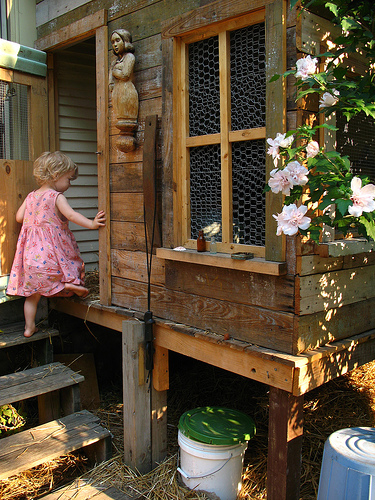

In [6]:
#Visualise both the images & text present in the dataset

imgPcap = readDataSet(capfilename,images)

tImgPath = list(imgPcap.keys())

tCapList = []
imgPathList = []

for image_path in tImgPath:
  capList = imgPcap[image_path]
  tCapList.extend(capList)
  imgPathList.extend([image_path] * len(capList))

print(list (imgPcap.values())[0])
Image.open(list (imgPcap.keys())[0])

In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    file = open(filename, 'r') # open the file as read only
    
    # read all text
    text = file.read()
    text = text.split('\n')
    
    # close the file
    file.close()
    
    return text

text_file = capfilename #location of caption file
doc = load_doc(text_file)
doc.pop(0) #to remove the header
print(doc[:300])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
all_img_id= [y.split(",")[0] for y in (doc) ] #store all the image id here
all_img_vector= copy.deepcopy(imgPathList) #store all the image path here
annotations= copy.deepcopy(tCapList) #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,<start> A little girl in a pink dress going in...
5,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> A black dog and a spotted dog are figh...
6,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> A black dog and a tri-colored dog play...
7,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> A black dog and a white dog with brown...
8,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> Two dogs of different breeds looking a...
9,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,<start> Two dogs on pavement moving toward eac...


In [9]:
#Create the vocabulary & the counter for the captions

words = list()

for i in range(len(df)):
    temp = df['Captions'][i]
    words = words + temp.split(' ')

vocabulary= words #write your code here

val_count=Counter(vocabulary)

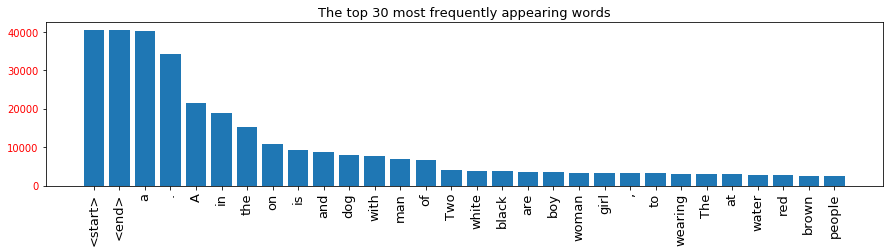

In [10]:
#Visualise the top 30 occuring words in the captions


#write your code here
def createDataFrameVocabulary(val_count):
    word = []
    count = []
    for i in val_count.keys():
        word.append(i)
    for j in val_count.values():
        count.append(j)
    data = {"word":word , "count":count}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfwordcount = createDataFrameVocabulary(val_count)

# Visualise top 30
def plthist(dfsub, title):
    plt.figure(figsize=(15,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=10,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=13)
    plt.title(title,fontsize=13)
    plt.show()

plthist(dfwordcount.iloc[:30,:], title="The top 30 most frequently appearing words")

In [11]:
#Create a list which contains all the captions
annotations= copy.deepcopy(tCapList) #write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= copy.deepcopy(imgPathList) #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# create the tokenizer

#your code here
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>" , filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(annotations)

In [13]:
# Create word-to-index and index-to-word mappings.

#your code here
print("Word-to-index mapping")
tokenizeWordToIndex = tokenizer.word_index
print(tokenizeWordToIndex)

print("\nIndex-to-word mapping")
tokenizeIndexToWord = (dict(map(reversed, tokenizer.word_index.items())))
print(tokenizeIndexToWord)

Word-to-index mapping
{'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'at': 23, 'people': 24, 'water': 25, 'red': 26, 'young': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'while': 36, 'shirt': 37, 'down': 38, 'standing': 39, 'ball': 40, 'little': 41, 'grass': 42, 'snow': 43, 'child': 44, 'person': 45, 'jumping': 46, 'over': 47, 'three': 48, 'front': 49, 'sitting': 50, 'holding': 51, 'up': 52, 'field': 53, 'small': 54, 'by': 55, 'large': 56, 'green': 57, 'one': 58, 'group': 59, 'yellow': 60, 'her': 61, 'walking': 62, 'children': 63, 'men': 64, 'into': 65, 'air': 66, 'beach': 67, 'near': 68, 'mouth': 69, 'jumps': 70, 'another': 71, 'for': 72, 'street': 73, 'runs': 74, 'its': 75, 'from': 76, 'riding': 77, 'stands': 78, 'as': 79, 'b

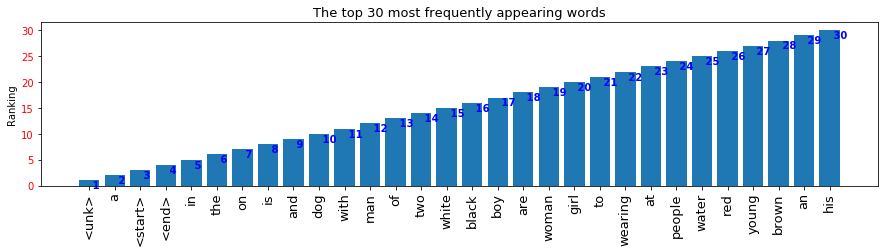

In [14]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
def createDataFrameTokenizer(val_count):
    word = []
    count = []
    for i in val_count.keys():
        word.append(i)
    for j in val_count.values():
        count.append(j)
    data = {"word":word , "count":count}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=True)
    dfword = dfword.reset_index()[["word","count"]]
    
    return(dfword)

dfTokenizeWordCount = createDataFrameTokenizer(tokenizeWordToIndex)

# Visualise top 30
def plthist(dfsub, title):
    plt.figure(figsize=(15,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.ylabel('Ranking')
    plt.yticks(fontsize=10,color ='r')
    for i, v in enumerate(dfsub["count"]-1):
      plt.text(v, i, " "+str(int(v)+1), color='blue', va='center', fontweight='bold')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=13)
    plt.title(title,fontsize=13)
    plt.show()

plthist(dfTokenizeWordCount.iloc[:30,:], title="The top 30 most frequently appearing words")

In [15]:
max_length = max(len(i.split(" ")) for i in annotations )


In [16]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_sequences = tokenizer.texts_to_sequences(annotations)

cap_vector= pad_sequences(train_sequences, padding='post', maxlen=max_length)  #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 40)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [17]:
#write your code here

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [18]:
#write your code here
imgCapVecDict = collections.defaultdict(list)
for img, cap in zip(imgPathList, cap_vector):
  imgCapVecDict[img].append(cap)

# Create training and test sets using an 80-20 split randomly.
img_keys = list(imgCapVecDict.keys())
random.shuffle(img_keys)

split = int(len(img_keys)*0.8)
img_train_keys, img_test_keys = img_keys[:split], img_keys[split:]

img_train = []
cap_train = []
for i in img_train_keys:
  capVeclen = len(imgCapVecDict[i])
  img_train.extend([i] * capVeclen)
  cap_train.extend(imgCapVecDict[i])

img_test = []
cap_test = []
for i in img_test_keys:
  capVeclen = len(imgCapVecDict[i])
  img_test.extend([i] * capVeclen)
  cap_test.extend(imgCapVecDict[i])


len(img_train), len(cap_train), len(img_test), len(cap_test)

(32360, 32360, 8095, 8095)

In [19]:
#write your code here

BATCH_SIZE = 64
BUFFER_SIZE = 1000

num_steps = len(img_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


# Get unique images
encode_train = sorted(set(imgPathList))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [21]:
# write your code to extract features from each image in the dataset
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

###
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda i1, i2: tf.numpy_function(
          map_func, [i1, i2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 40)


In [23]:
## create test dataset as well
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda i1, i2: tf.numpy_function(
          map_func, [i1, i2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [24]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 40)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [25]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_dataset) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(test_dataset) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [26]:

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim, input_shape=(2048,), activation='relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [27]:
encoder=Encoder(embedding_dim)

### Attention model

In [28]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        #print(features.shape)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [29]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [31]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [32]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #define your loss object

In [33]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
checkpoint_path_ckpt = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [36]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training stepz
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [37]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    features = encoder(img_tensor)

    for i in range(1,target.shape[1]):
      ## get caption from decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], predictions)

      predicted_id = tf.argmax(predictions[0])
      dec_input = tf.expand_dims([predicted_id]*target.shape[0],1)
    
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [38]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate (test_dataset):
      batch_loss, total_b_loss = test_step(img_tensor, target)
      total_loss += total_b_loss
    avg_test_loss =total_loss / train_num_steps
    
    return avg_test_loss

In [39]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 89.448, & test loss is 33.544
Time taken for 1 epoch 1538.749683856964 sec

Test loss has been reduced from 100.000 to 33.544


 13%|█▎        | 2/15 [48:39<5:23:12, 1491.75s/it]

For epoch: 2, the train loss is 69.796, & test loss is 34.808
Time taken for 1 epoch 1380.4861707687378 sec



 20%|██        | 3/15 [1:11:11<4:49:55, 1449.66s/it]

For epoch: 3, the train loss is 63.303, & test loss is 34.793
Time taken for 1 epoch 1351.4321455955505 sec



 27%|██▋       | 4/15 [1:33:30<4:19:40, 1416.42s/it]

For epoch: 4, the train loss is 58.728, & test loss is 35.196
Time taken for 1 epoch 1338.858139514923 sec



 33%|███▎      | 5/15 [1:55:35<3:51:29, 1388.95s/it]

For epoch: 5, the train loss is 54.986, & test loss is 36.342
Time taken for 1 epoch 1324.842446088791 sec



 40%|████      | 6/15 [2:17:37<3:25:20, 1368.91s/it]

For epoch: 6, the train loss is 51.788, & test loss is 37.604
Time taken for 1 epoch 1322.1702420711517 sec



 47%|████▋     | 7/15 [2:39:48<3:01:01, 1357.65s/it]

For epoch: 7, the train loss is 48.836, & test loss is 38.237
Time taken for 1 epoch 1331.3816843032837 sec



 53%|█████▎    | 8/15 [3:18:22<3:11:52, 1644.64s/it]

For epoch: 8, the train loss is 46.198, & test loss is 39.237
Time taken for 1 epoch 2314.2706122398376 sec



 60%|██████    | 9/15 [4:03:44<3:16:45, 1967.65s/it]

For epoch: 9, the train loss is 43.687, & test loss is 39.701
Time taken for 1 epoch 2721.3332369327545 sec



 67%|██████▋   | 10/15 [4:49:06<3:02:49, 2193.93s/it]

For epoch: 10, the train loss is 41.362, & test loss is 40.817
Time taken for 1 epoch 2721.925261735916 sec



 73%|███████▎  | 11/15 [5:27:11<2:28:05, 2221.48s/it]

For epoch: 11, the train loss is 39.277, & test loss is 42.438
Time taken for 1 epoch 2285.7684321403503 sec



 80%|████████  | 12/15 [5:51:20<1:39:28, 1989.46s/it]

For epoch: 12, the train loss is 37.255, & test loss is 43.103
Time taken for 1 epoch 1448.0632548332214 sec



 87%|████████▋ | 13/15 [6:15:42<1:01:02, 1831.42s/it]

For epoch: 13, the train loss is 35.388, & test loss is 43.612
Time taken for 1 epoch 1462.637359380722 sec



 93%|█████████▎| 14/15 [6:39:44<28:34, 1714.65s/it]  

For epoch: 14, the train loss is 33.686, & test loss is 44.920
Time taken for 1 epoch 1442.1308588981628 sec



100%|██████████| 15/15 [7:03:54<00:00, 1635.27s/it]

For epoch: 15, the train loss is 32.105, & test loss is 46.479
Time taken for 1 epoch 1450.0477457046509 sec



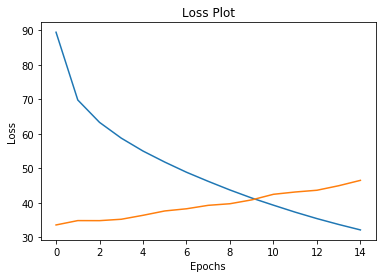

In [40]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [42]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
                  
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length,attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0],0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val,(img_tensor_val.shape[0], -1,
                                                img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)

    while len(result[0][0]) < max_length:
      i=0
      temp=[]
      for s in result:
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        i=i+1

        word_preds = np.argsort(predictions[0])[-beam_index:]

        for w in word_preds:
          next_cap,prob = s[0][:],s[1]
          next_cap.append(w)
          prob += predictions[0][w]
          temp.append([next_cap , prob])
      result = temp
      result = sorted(result, reverse=False, key=lambda l:l[1])
      result = result[-beam_index:]

      prediction_id = result[-1]
      pred_list = prediction_id[0]
      
      prd_id = pred_list[-1]
      if (prd_id!=3):
        dec_input = tf.expand_dims([prd_id],0)
      else:
        break
    
    result = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
      if i!='<end>':
        if i!='<start>':
          final_caption.append(i)
      else:
        break

    final_caption = ' '.join(final_caption[1:])

    return final_caption



In [43]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [44]:
from nltk.translate.bleu_score import sentence_bleu

In [45]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/mnt/disks/user/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

BELU score: 17.310993243825866
Real Caption: children are playing in and around a garden tube in the front yard of a house
Prediction Caption: a young boy in blue blue dress kicks a blue car


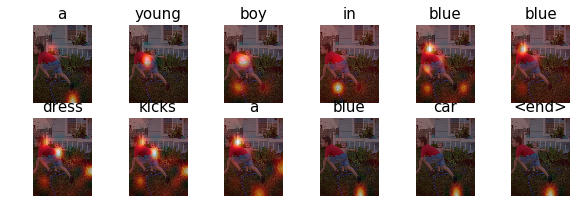

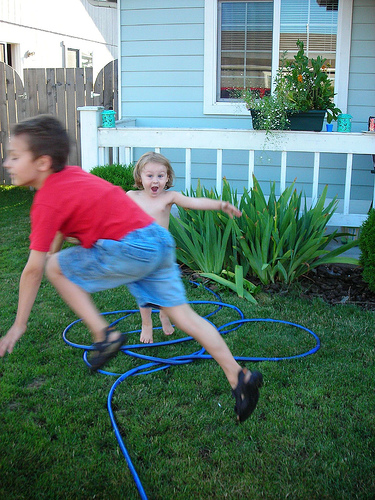

In [46]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [47]:
captions=beam_evaluate(test_image)
print(captions)

boy boy in a pink frisbee
